# Explainability Analysis

This document looks at model explainability in the context of the [Google Explainability Whitepaper](https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf), seeking to answer a number of questions:

1. Tradeoffs of several approaches in identifying feature importance:
    1. Sampled Shapley
    2. Integrated Gradients
2. Are there any other methods that perform well in identifying feature importance without access to the internal details of a model.

In addition to the Google Explainability Whitepaper and various academic works cited, this document also draws on insights from Christoph Molnar's [Interpretable Machine Learning Book](https://christophm.github.io/interpretable-ml-book/).

In [1]:
# Start by loading necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, max_error, explained_variance_score
from sklearn.inspection import plot_partial_dependence
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from anchor import utils
from anchor import anchor_tabular

## Simulated example

Suppose you have data ($n = 1000$) with the following features:

$X_1, X_2, X_3 \sim \textrm{Normal}(0, 1)$

$X_4, X_5 \sim \textrm{Bernoulli}(0.1)$

$Y = 5 - X_1 + X_2 - 5X_3 + 10X_4 - 20X_5 + \varepsilon$

where $\varepsilon \sim \textrm{Normal}(0, 1)$

Thus, $X_1 - X_3$ are independent standard normal, $X_4$ and $X_5$ are flipped to "1" roughly 10% of the time, and $Y$ is linear in each of the features.

In [2]:
# Set randomization seed for replicability of simulated data
np.random.seed(2020)

# Generate random data
n = 1000; sigma = 1
X_np = np.concatenate((np.random.normal(loc = 0, scale = 1, size = (n, 3)), 
                       np.random.binomial(n = 1, p = 0.1, size = (n, 2))), axis = 1)
X_df = pd.DataFrame(X_np, columns = ["X1", "X2", "X3", "X4", "X5"])
error_term = np.random.normal(loc = 0, scale = sigma^2, size = (n))
y = (5 - X_df["X1"] + X_df["X2"] - 5*X_df["X3"] + 
     10*X_df["X4"] - 20*X_df["X5"] + error_term)

Look at the relationships between variables in the simulated dataset (they seem roughly in keeping with the above equation)

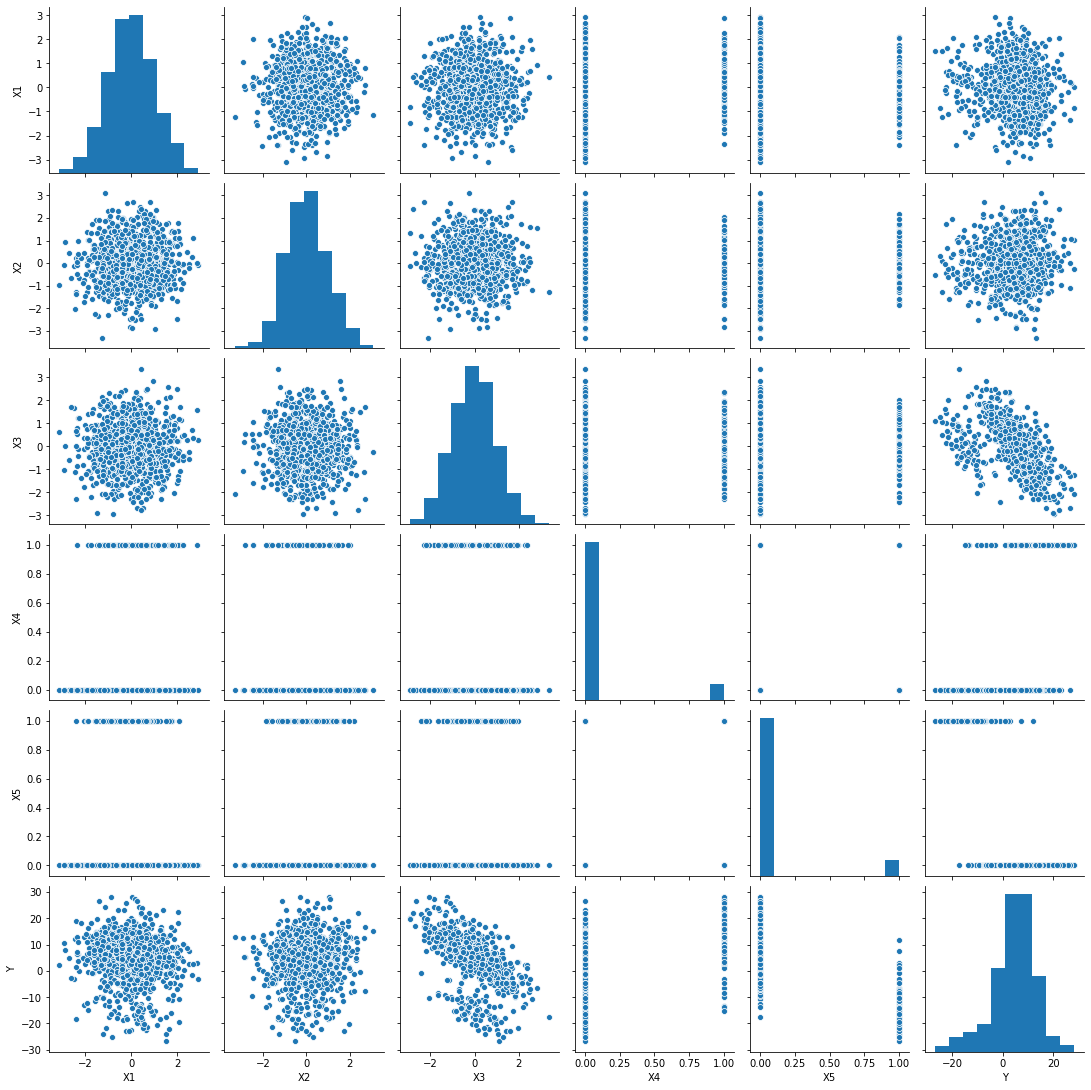

In [3]:
viz_df = X_df.copy(); viz_df["Y"] = y
sns.pairplot(viz_df)

Split the data into test/train sets and scale to standardized range (scaling should have very little impact since the data is already either binary or standard normal).

In [4]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_df, y, test_size=0.33, random_state=42)
data_scale = StandardScaler()
X_train = np.concatenate((data_scale.fit_transform(X_train_raw[["X1", "X2", "X3"]]), 
                          X_train_raw[["X4", "X5"]]), axis = 1)
X_test = np.concatenate((data_scale.transform(X_test_raw[["X1", "X2", "X3"]]), 
                         X_test_raw[["X4", "X5"]]), axis = 1)

Predict $Y$ using several methods:
1. Linear Regression
2. Decision Tree
3. Random Forest
4. Support Vector Machine
5. Multi-layer Perceptron

Then run some quick performance metrics on test set

In [5]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Support Vector Machine", SVR()),
    ("Random Forest", RandomForestRegressor()), 
    ("Bayesian Ridge Regression", BayesianRidge()), 
    ("MLP", MLPRegressor(hidden_layer_sizes=(100, 100), 
                                    tol=1e-2, max_iter=500, random_state=0))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    var_explained = explained_variance_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    Max_Err = max_error(y_test, y_pred)
    print("Model: {}; Variance explained: {:,.2%}; MSE: {:,.2f}; Max Error: {:,.2f}".format(
        name, var_explained, MSE, Max_Err
    ))

Model: Linear Regression; Variance explained: 86.01%; MSE: 9.45; Max Error: 9.87
Model: Decision Tree; Variance explained: 71.98%; MSE: 19.05; Max Error: 16.04
Model: Support Vector Machine; Variance explained: 68.42%; MSE: 21.33; Max Error: 16.26
Model: Random Forest; Variance explained: 82.49%; MSE: 11.84; Max Error: 10.89
Model: Bayesian Ridge Regression; Variance explained: 86.02%; MSE: 9.45; Max Error: 9.87
Model: MLP; Variance explained: 86.11%; MSE: 9.39; Max Error: 9.44


Random forest, MLP and variations of linear regression (OLS and ridge) all seem promising, so let's assume those become the models that we want to start inspecting as we prepare for deployment. For now, we'll store them as separate variables.

In [6]:
linreg_model = models[0][1]
rf_model = models[3][1]
mlp_model = models[5][1]

Assume that we're about to deploy the random forest model in production and want to really understand how it's working. We first consider using Shapley Additive Explanations (SHAP), a well-known technique among ML practitioners, which can be used to explain individual predictions and also aggregate across an entire suite of explanations.

Pick a random datapoint

In [7]:
random_datapoint = np.random.choice(np.arange(np.shape(X_test)[0]), 1)[0]

Look at the datapoint's:
* Original feature values
* Re-scaled feature values
* Predicted outcome (by each model)
* Actual outcome

In [8]:
print("Original feature values")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Scaled feature values")
print("{}\n".format(pd.Series(X_test[random_datapoint,], index = X_df.columns)))
for name, model in models:
    y_pred = model.predict(X_test[random_datapoint,].reshape(1, -1))[0]
    print("Model: {}; Predicted Value: {:,.2f}".format(name, y_pred))
print("\nActual outcome: {:,.2f}".format(y_test.iloc[random_datapoint]))

Original feature values
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Scaled feature values
X1    0.475861
X2    2.185475
X3   -1.106144
X4    0.000000
X5    0.000000
dtype: float64

Model: Linear Regression; Predicted Value: 12.21
Model: Decision Tree; Predicted Value: 10.87
Model: Support Vector Machine; Predicted Value: 8.99
Model: Random Forest; Predicted Value: 10.54
Model: Bayesian Ridge Regression; Predicted Value: 12.21
Model: MLP; Predicted Value: 11.34

Actual outcome: 12.46


### Method \#1. Partial Dependence Plots

One of the earliest approaches to explaining feature-level effects in a model is the Partial Dependence Plot ([Friedman (2001)](https://projecteuclid.org/euclid.aos/1013203451)), which looks at the predicted value of a model for each value of a given input feature after averaging out the values of the remaining features. 

This is roughly equivalent to the interpretation "holding all other features equal, how do predictions vary based on this feature?"

Intuitively, this approach works well when features are independent and there are not complicated interactions between the features and the outcome. Given our simulated data, we'll see that PDP works perfectly fine in this case, but we will see in future cases, PDP plots obscure reality.

Let's look at the impact of $X_1$ and $X_4$ on our random forest model's predictions. Based on the equation, predicted values should decrease linearly with $X_1$ and by a jump of about $10$ when activating $X_4 = 1$.

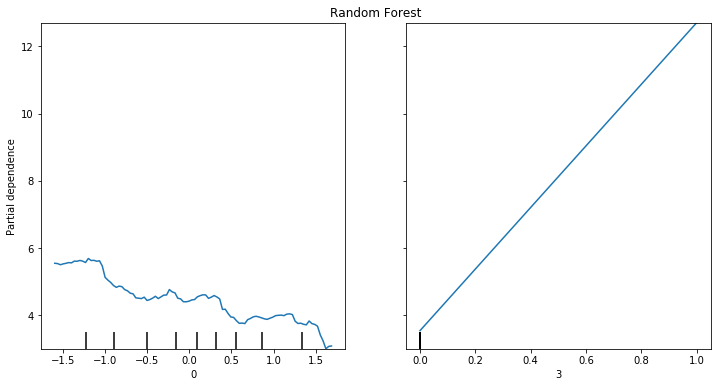

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Random Forest")
tree_disp = plot_partial_dependence(rf_model, X_test, [0, 3], ax=ax)

The trend certainly isn't perfectly linear, as we wouldn't expect a random forest to outperform a linear model when the data is truly linear. (However, in the real world, it's often difficult to plausibly assume an unknown model is linear, which is why tree ensembles, as well as neural networks, are popular.)

### Method \#2. Individual Conditional Expectations (ICE)

The next approach we consider is ICE, or Individual Conditional Expectations ([Goldstein et al (2015)](https://arxiv.org/abs/1309.6392)). 

Broadly, this is a non-averaged version of Friedman's partial dependence plots, which produces $n$ separate partial dependence plots. For each of the $n$ points in a dataset, the feature of interest is varied across its entire range while the remaining features are held constant at their original value for each sample.

In [10]:
def compute_ICE(model, data, column):
    """
    Produce ICE (Individial Conditional Expectation) estimates for each datapoint
    
    :param model: model object with a `.predict()` method
    :param data: dataset over which to compute partial dependence relationships
    :param column: (double) column index number(s) of numpy array
    :return: pd.Series of conditional expected values for each sample and each unique value of `column`
    """
    num_rows = np.shape(data)[0]
    Xc = np.sort(np.unique(data[:, column]))
    num_unique_vals = np.shape(Xc)[0]
    fixed_col_nums = np.delete(range(np.shape(data)[1]), column)
    fixed_cols = data[:, fixed_col_nums]
    fixed_cols_tiled = np.repeat(fixed_cols, num_unique_vals, axis=0)
    Xc_repeated = np.tile(Xc, num_rows)
    ICE_data = np.insert(fixed_cols_tiled, column, Xc_repeated, axis=1)
    row_indices = np.arange(num_rows)
    unique_indices = np.arange(num_unique_vals)
    return pd.Series(model.predict(ICE_data), 
        index = pd.MultiIndex.from_product([row_indices, unique_indices], 
                                           names=['first', 'second'])
    ), Xc

In [11]:
def plot_ICE(ice_output, Xc, column_num):
    """
    Produce individual plots of ICE results
    
    :param ice_output: result of running `compute_ICE`
    :param Xc: List of unique variables for the column of interest
    :param column_num: column of interest
    :return: plot, printed to console
    """
    for obs, obs_df in ice_output.groupby(level=0):
        plt.plot(Xc, obs_df.values, color = "#5f6a6a")
    plt.ylabel('Partial predictions')
    plt.xlabel('Column number {:,.0f}'.format(column_num))
    plt.show()

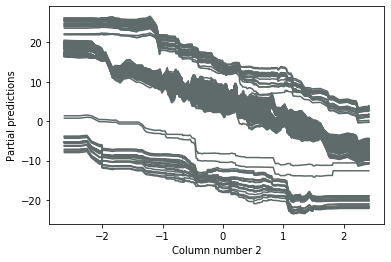

In [12]:
column = 2
ice_predictions, Xc = compute_ICE(rf_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

Well, this actually does a pretty good job of capturing the heterogeneity in our data. The giant cluster in the middle is the majority of datapoints for which both $X_4$ and $X_5$ are equal to $0$, the cluster above that is data with $X_4 = 1$ and $X_5 = 0$ (hence, predictions are higher on average because the outcome is higher on average), the bottom cluster is where $X_4 = 0$ and $X_1 = 1$ and the middle cluster represents the small number of cases in which both $X_4 = 1$ and $X_5 = 1$.

Thus, this method alerts us to the heterogeneity in the data and gives us some direction to explore which features might be driving that separation. If we re-run the ICE plot for one of the binary variables, we see that the equivalent of "activating" the variable leads to a big jump in predictions, confirming that this may be the source of the stratification.

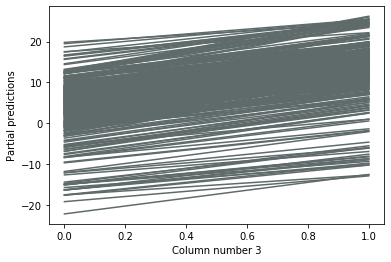

In [13]:
column = 3
ice_predictions, Xc = compute_ICE(rf_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

### Method \#3. SHAP

Next, we look at several explainability methods which fall under the broad umbrella of the Shapley value approach.

### Method \#3a. KernelSHAP

Kernel SHAP is described in [Lundberg and Lee (2017)](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) and is implemented in the `shap` Python library.

Broadly, this approach is model-agnostic. A "background" dataset is provided which is used to compute a baseline model prediction (in the case of numeric / tabular data, this would be akin to an average prediction). A "target" data point (or points) is provided, and then combinations of features are converted from baseline values to target values. After assessing the model prediction on a number of combinations of baseline feature values and target feature values, a weighted linear regression model is fit to allocate the difference between the target prediction and the baseline prediction to each of the model's features.

We start by computing Shapley values for the entire test set, using the training set as the background values.

In [14]:
explainer = shap.KernelExplainer(rf_model.predict, X_train)
%time shap_values = explainer.shap_values(X_test, nsamples=100, l1_reg="num_features(10)")

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



CPU times: user 1min 17s, sys: 1.33 s, total: 1min 19s
Wall time: 1min 40s


Now, we look at the shapley values for `random_datapoint` (picked above at random)

In [15]:
target_pred = rf_model.predict(X_test[random_datapoint, :].reshape(1, -1))
avg_training_pred = np.mean(rf_model.predict(X_train))
print("Difference in baseline and target prediction: {:,.2f}".format((target_pred - avg_training_pred)[0]))

Difference in baseline and target prediction: 6.35


In [16]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Shapley values for each feature
X1   -0.287613
X2    0.239017
X3    5.435489
X4   -1.065315
X5    2.029667
dtype: float64


These coefficients look a little bit off, because the non-zero Shapley values for $X_4$ and $X_5$ seem to suggest that setting these features to $0$ causes a decrease in average predictions, when the intuitive interpretation of a binary feature is that $0$ is the baseline category. So why does setting each of these variables equal to the baseline result in a decrease in expected predictions?

The answer is simple: since we've used the entire training set as our "baseline," and both $X_4$ and $X_5$ are set to $1$ about $10\%$ of the time, the "baseline" value for these binary features is roughly 0.10 (see below). Since $X_5$ has a coefficient of $-20$, moving from $X_5 = 0.1$ to $X_5 = 0$ increases the predicted values by roughly 2, so this makes sense

In [17]:
pd.DataFrame(X_train_raw).describe()

,X1,X2,X3,X4,X5
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,-0.008105,-0.012885,-0.046002,0.095522,0.097015
std,1.009363,0.955795,1.002836,0.294155,0.296199
min,-3.103170,-2.924010,-2.941374,0.000000,0.000000
25%,-0.650770,-0.620191,-0.702345,0.000000,0.000000
50%,-0.037555,-0.046473,-0.036932,0.000000,0.000000
75%,0.678408,0.582438,0.598189,0.000000,0.000000
max,2.911685,2.716387,3.367824,1.000000,1.000000


But it complicates interpretation. Let's look at an alternative that involves manually specifying a baseline or a list of baselines.

By the way, this approach might be preferable not just for the reason highlighted above, but also for computational and / or legal reasons. If everytime you wanted to explain a model, you had to train an explainer on the original training data, that would be not ideal.

Regardless, each of these methods does still rely on some sort of "comparison" reference values, so at the very least, we'll need to know the dimensionality and data types of the features. But from there, we have a few possibilities for explaining new predictions without access to the original training data:

* Choose one carefully constructred baseline. In the context of images, the Google whitepaper mentions using all black pixels or all white pixels. For tabular data, the whitepaper suggests using medians / modes.
* Pick several baselines and take an average of computed shapley values (this is what `KernelExplainer` is doing with the training data in the above example).

We start with the first choice and since our numeric data is normal, the median is zero. Similarly, since the categorical data is $p = 0.1$, the mode is 0, so we pass a baseline of all zeros through our data scaling process and then proceed to explain `random_datapoint` in contrast to this zeroed out baseline value.

In [18]:
baseline_data_raw = np.array([[0,0,0,0,0]])
baseline_data = np.concatenate((data_scale.transform(baseline_data_raw[0][:3].reshape(1, -1)), 
                                baseline_data_raw[0][3:].reshape(1, -1)), axis = 1)

explainer = shap.KernelExplainer(rf_model.predict, baseline_data)
%time shap_values = explainer.shap_values(X_test[random_datapoint, :].reshape(1, -1), nsamples=100, l1_reg="num_features(10)")


CPU times: user 53.6 ms, sys: 5.77 ms, total: 59.4 ms
Wall time: 87.6 ms


In [19]:
target_pred = rf_model.predict(X_test[random_datapoint, :].reshape(1, -1))
baseline_training_pred = np.mean(rf_model.predict(baseline_data))
print("Difference in baseline and target prediction: {:,.2f}".format(
    (target_pred - baseline_training_pred)[0])
)

Difference in baseline and target prediction: 4.64


In [20]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[0], index = X_df.columns)))

Original model inputs:
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Shapley values for each feature
X1   -0.585463
X2    1.244577
X3    3.977060
X4    0.000000
X5    0.000000
dtype: float64


This is a bit different in that the model no longer attributes any explanatory value to $X_4$ or $X_5$, which makes sense since both the baseline and target values are $0$ for those features. However, we do still see that $X_3$ pops as the most relevant feature here, even though $X_2$ has a more extreme (relative to the standard normal mean) value.

### Method \#3b. TreeSHAP

Tree SHAP is described in [Lundberg and Lee (2019)](https://arxiv.org/pdf/1802.03888.pdf) and is also implemented in the `shap` Python library.

Unlike Kernel SHAP, Tree SHAP is not model-agnostic and only works for various tree ensemble methods (xgboost, gradient boosted trees, random forest). The mechanics of the approach, however, are similar. 

The key difference is a computational trick that takes advantage of the recursive structure of trees to estimate Shapley values much faster. **It is worth noting that this method requires access to the internals of a model object.**

We compute Shapley values for the entire test set, using the training set as the background values.

In [21]:
explainer = shap.TreeExplainer(rf_model, X_train)
%time shap_values = explainer.shap_values(X_test, y_test)

100%|===================| 329/330 [00:49<00:00]        

CPU times: user 31.3 s, sys: 576 ms, total: 31.9 s
Wall time: 48.3 s


Now, we look at the shapley values for `random_datapoint` (picked above at random)

In [22]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Shapley values for each feature
X1   -0.287613
X2    0.239017
X3    5.435489
X4   -1.065315
X5    2.029667
dtype: float64


The Shapley values in this case are the same. Unfortunately, the computational speedup is delivered by using the specific trees in the model, which goes against our premise of not accessing model internals.

### Method \#4. Integrated Gradients

Integrated gradients are introduced in [Sundarajan et al (2017)](https://arxiv.org/pdf/1703.01365.pdf).

In order to explain our our prediction via the Integrated Gradient approach, we must first fit a simple deep learning model to the simulated data, which we'll do using `tf.keras` (following [this example](https://www.tensorflow.org/tutorials/keras/regression)).

In [23]:
model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[np.shape(X_train)[1]]), 
        layers.Dense(4, activation='relu'), layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', 
              metrics=['sparse_categorical_accuracy'])

In [24]:
# Convert numpy arrays to tf datasets
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Max number of epochs
EPOCHS = 1000
# Patience parameter
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# Train model, storing metrics along the way
history = model.fit(train_dataset, epochs=EPOCHS, verbose=0, 
                    callbacks=[early_stop])

# Compute predicted values of test dataset
test_predictions = model.predict(test_dataset).flatten()

We use the integrated gradient computations provided by the `shap` library in the `GradientExplainer` class. The shap documentation explains that the approach is similar to that of the original `Integrated_Gradients` library, but rather than requiring a specific starting point, it can average across a number of base values in the background dataset.

Here, we compute the Shapley values for the entire test set, using the training set as background data.

In [25]:
explainer = shap.GradientExplainer(model, X_train)
%time shap_values = explainer.shap_values(X_test)

CPU times: user 3.65 s, sys: 149 ms, total: 3.8 s
Wall time: 4.25 s


In [26]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[0][random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Shapley values for each feature
X1   -0.615125
X2    0.959300
X3    4.807927
X4   -1.246579
X5    1.591553
dtype: float64


We see that the results are similar with a *significant* improvement in computation time. Unfortunately, this approach, too, requires access to model internals in the form of gradients.

Let's see how this same approach fares when moving from one baseline value (in this case, our zeroed-out data vector)

In [27]:
baseline_data_raw = np.array([[0,0,0,0,0]])
baseline_data = np.concatenate((data_scale.transform((baseline_data_raw[0][:3]).reshape(1, -1)), 
                                (baseline_data_raw[0][3:]).reshape(1, -1)), axis = 1)

explainer = shap.GradientExplainer(model, baseline_data)
%time shap_values = explainer.shap_values(X_test[random_datapoint, :].reshape(1, -1))

CPU times: user 132 ms, sys: 3.23 ms, total: 135 ms
Wall time: 135 ms


In [28]:
target_pred = model.predict(X_test[random_datapoint, :].reshape(1, -1))
baseline_training_pred = np.mean(model.predict(baseline_data))
print("Difference in baseline and target prediction: {:,.2f}".format((target_pred[0][0] - baseline_training_pred)))

Difference in baseline and target prediction: 2.26


In [29]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[0][0], index = X_df.columns)))

Original model inputs:
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Shapley values for each feature
X1   -1.036874
X2   -0.490960
X3    3.604815
X4    0.000000
X5    0.000000
dtype: float64


Similar results, although we can see that (a) either the neural network doesn't quite pick up on the level of importance of $X_2$ or (b) the explainer model isn't working as well in this case.

### Method \#5. Lime

LIME is discussed in [Ribeiro et al (2016)](https://arxiv.org/pdf/1602.04938.pdf).

LIME fits a locally-weighted regression in a series of random samples around a target data point. LIME can either accept training data or training data statistics which it will use for sampling purposes.

In the first case, let's supply our standard baseline value of zeros for each feature as the "training data" and see how LIME performs.

In [30]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    baseline_data, feature_names=X_df.columns, categorical_features = [3, 4], 
    class_names=['Y'], verbose=True, mode='regression', random_state = 1234, 
    discretize_continuous = False
)
exp = explainer.explain_instance(X_test[random_datapoint], rf_model.predict, num_features=5)
for item in exp.as_list():
    print(item)

Intercept 5.0071724659192745
Prediction_local [11.78586024]
Right: 10.536800168269078
('X3', -5.12902356056974)
('X1', -0.6675362749160892)
('X2', 0.5442414674844446)
('X4=0', 0.0)
('X5=0', 0.0)


This seems to be roughly in keeping with the Shapley values for each feature, though the interpretation is a slightly different. Rather than attributing features to a difference in predictions, this is simply reporting the linear model coefficients in a neighborhood of samples around the target value. Since our original data was generated by a linear regression, in this case LIME has essentially learned the underlying linear model coefficients for $X_1 - X_3$ (to an approximation, since they're mediated by a random forest model of the data).

Also, note that the reason the coefficients on $X_4$ and $X_5$ are $0$ is that LIME constructs a neighborhood around the target value by perturbing continuous variables with noise and by sampling with replacement from the empirical frequencies of categorical columns. Without any data other than the baseline, our empirical frequencies are both $0\%$. 

One way to overcome this is to pass along training statistics. So, let's compute training data statistics in the format needed for LIME.

In [31]:
# Extract training data stats for explainability methods
means = pd.DataFrame(X_train).describe().T["mean"].to_dict()
mins = pd.DataFrame(X_train).describe().T["min"].to_dict()
maxs = pd.DataFrame(X_train).describe().T["max"].to_dict()
stds = pd.DataFrame(X_train).describe().T["std"].to_dict()

# Get list of unique features and counts for the categorical columns
feature_values = {}
feature_counts = {}
for srs in range(3, 5):
    feature_name = "X{}".format(srs)
    feature_values[srs] = pd.Series(X_train[:, srs]).value_counts().keys().to_list()
    feature_counts[srs] = list(pd.Series(X_train[:, srs]).value_counts().values)

# Combine everything into a dictionary that can be passed to LIME
X_train_stats = {}
X_train_stats["means"] = means
X_train_stats["mins"] = mins
X_train_stats["maxs"] = maxs
X_train_stats["stds"] = stds
X_train_stats["feature_values"] = feature_values
X_train_stats["feature_frequencies"] = feature_counts

In [32]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    baseline_data, feature_names=X_df.columns, categorical_features = [3, 4], 
    class_names=['Y'], verbose=True, mode='regression', random_state = 1234, 
    training_data_stats = X_train_stats, discretize_continuous = False
)
exp = explainer.explain_instance(X_test[random_datapoint], rf_model.predict, num_features=5)
for item in exp.as_list():
    print(item)

Intercept -6.143141388033307
Prediction_local [11.80194006]
Right: 10.536800168269078
('X5=0', 20.452273886975572)
('X4=0', -9.294124346169587)
('X3', -5.002253023952299)
('X1', -0.6477799064142851)
('X2', 0.6110226687760832)


Here we see that all of the true model coefficients are recovered, because LIME was able to sample from a larger area around `X_test[random_datapoint]` with the use of training statistics.

## (More Complex) Simulated Data Example

We have seen that while the above methods each have their advantages and disadvantages, none of them really had a breaking point given the separable linear trends in the first dataset we simulated.

So now we simulate data ($n = 1000$) with sparsity and interaction terms:

$X_1 - X_{6} \sim \textrm{Normal}(0, 1)$

$X_{7}, X_{8} ~ \sim \textrm{Bernoulli}(0.5)$

$Y = 5 - 5X_1 + 10X_2 - 10X_3 + 10X_1X_{8} - 20X_2X_{7} + \varepsilon$

$\varepsilon \sim \textrm{Normal}(0, 1)$

Thus, $X_1 - X_{6}$ are independent standard normal, $X_{7}$ and $X_{8}$ are flipped to "1" roughly half of the time, and $Y$ is only impacted by $X_1$, $X_2$, $X_3$ and interactions between $X_1$ and $X_{8}$ and $X_2$ and $X_{7}$.

In [33]:
# Set randomization seed for replicability of simulated data
np.random.seed(2020)

# Generate random data
n = 1000; sigma = 1
X_np = np.concatenate((np.random.normal(loc = 0, scale = 1, size = (n, 6)), 
                       np.random.binomial(n = 1, p = 0.5, size = (n, 2))), axis = 1)
X_df = pd.DataFrame(X_np, columns = ["X{}".format(elem) for elem in range(1, 9)])
error_term = np.random.normal(loc = 0, scale = sigma^2, size = (n))
y = (5 - 5*X_df["X1"] + 10*X_df["X2"] - 10*X_df["X3"] + 
     10*X_df["X1"]*X_df["X8"] - 20*X_df["X2"]*X_df["X7"] + error_term)

Split the data into test/train sets and scale to standardized range

In [34]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_df, y, test_size=0.33, random_state=42)
data_scale = StandardScaler()
continuous_column_labels = ["X{}".format(elem) for elem in range(1, 7)]
X_train = np.concatenate((data_scale.fit_transform(X_train_raw[continuous_column_labels]), 
                          X_train_raw[["X7", "X8"]]), axis = 1)
X_test = np.concatenate((data_scale.transform(X_test_raw[continuous_column_labels]), 
                         X_test_raw[["X7", "X8"]]), axis = 1)
# X_train = data_scale.fit_transform(X_train_raw)
# X_test = data_scale.transform(X_test_raw)

Predict $Y$ using several methods:
1. Linear Regression
2. Decision Tree
3. Support Vector Machine
4. Random Forest
5. Gradient Boosting
6. Multi-layer Perceptron

Then run some quick performance metrics on test set

In [35]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Lasso", LassoCV(cv=10)),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Support Vector Machine", SVR()),
    ("Random Forest", RandomForestRegressor()), 
    ("Gradient Boosting", GradientBoostingRegressor()), 
    ("Bayesian Ridge Regression", BayesianRidge()), 
    ("MLP", MLPRegressor(hidden_layer_sizes=(100, 100), 
                                    tol=1e-2, max_iter=500, random_state=0))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    var_explained = explained_variance_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    Max_Err = max_error(y_test, y_pred)
    print("Model: {}; Variance explained: {:,.2%}; MSE: {:,.2f}; Max Error: {:,.2f}".format(
        name, var_explained, MSE, Max_Err
    ))

Model: Linear Regression; Variance explained: 43.37%; MSE: 144.60; Max Error: 34.83
Model: Lasso; Variance explained: 43.00%; MSE: 145.53; Max Error: 33.64
Model: Decision Tree; Variance explained: 7.34%; MSE: 236.75; Max Error: 60.08
Model: Support Vector Machine; Variance explained: 48.96%; MSE: 130.36; Max Error: 33.23
Model: Random Forest; Variance explained: 56.90%; MSE: 110.16; Max Error: 32.55
Model: Gradient Boosting; Variance explained: 68.03%; MSE: 81.66; Max Error: 32.26
Model: Bayesian Ridge Regression; Variance explained: 43.31%; MSE: 144.73; Max Error: 34.74
Model: MLP; Variance explained: 94.51%; MSE: 14.01; Max Error: 13.39


With the heavy interaction terms, it seems only the MLP performs well on this data. It is likely that with hyperparameter tuning, the tree ensemble models (RF and GB) would perform well on this dataset, and using xgboost or BART could also lead to strong performance, but for now, we proceed as though we're ready to examine our MLP model for possible deployment.

In [36]:
mlp_model = models[7][1]

### Method \#1. Partial Dependence Plots

Let's look at the impact of $X_1$ and $X_{2}$ on our model's predictions.

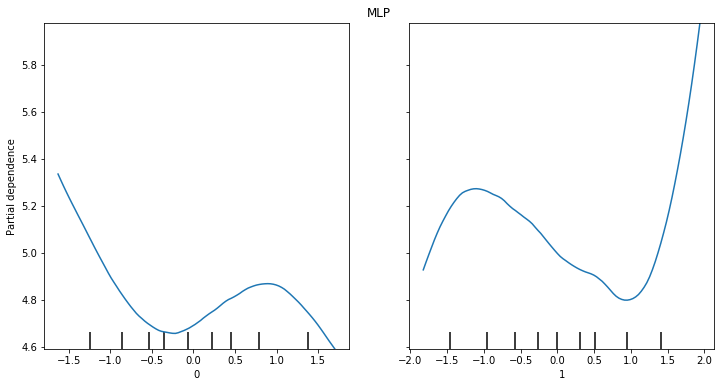

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("MLP")
tree_disp = plot_partial_dependence(mlp_model, X_test, [0, 1], ax=ax)

The shape seems a bit awkward and doesn't give the reader any sense that this complexity is caused by interaction terms on the features.

### Method \#2. Individual Conditional Expectations (ICE)

Next, we look at ICE plots for $X_1$ and $X_2$

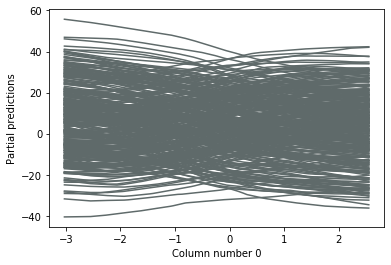

In [38]:
column = 0
ice_predictions, Xc = compute_ICE(mlp_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

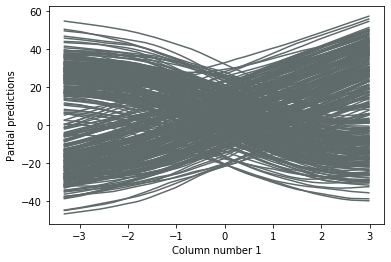

In [39]:
column = 1
ice_predictions, Xc = compute_ICE(mlp_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

This seems to be what we'd expect. About half of the time, the plot is a positive linear trend, and the other half of the time, the plot is a negative linear trend, alerting us to interaction effects in the model.

Let's see how the plots handle features with no impact.

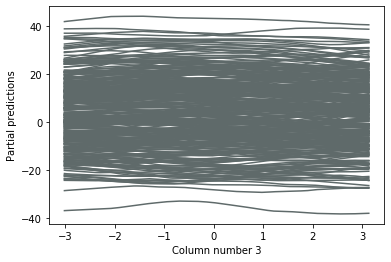

In [40]:
column = 3
ice_predictions, Xc = compute_ICE(mlp_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

Seems mostly flat, although there does appear to be a somewhat linear trend in some cases. It is highly possible that our model is overfit given the number of parameters in the MLP.

### Method \#3. SHAP

Next, we look at several explainability methods which fall under the broad umbrella of the Shapley value approach.

### Method \#3a. KernelSHAP

Compute Shapley values for the entire test set, using the training set as the background values.

In [41]:
explainer = shap.KernelExplainer(mlp_model.predict, X_train)
%time shap_values = explainer.shap_values(X_test, nsamples=100, l1_reg="num_features(22)")

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



CPU times: user 3min 22s, sys: 7.71 s, total: 3min 30s
Wall time: 3min 6s


Now, we look at the Shapley values for `random_datapoint` (picked above at random)

In [42]:
target_pred = mlp_model.predict(X_test[random_datapoint, :].reshape(1, -1))
avg_training_pred = np.mean(mlp_model.predict(X_train))
print("Difference in baseline and target prediction: {:,.2f}".format((target_pred - avg_training_pred)[0]))

Difference in baseline and target prediction: 13.49


In [43]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1   -0.857534
X2   -0.094733
X3   -1.610128
X4   -1.373739
X5    0.317570
X6    0.664165
X7    1.000000
X8    1.000000
dtype: float64

Shapley values for each feature
X1    -2.470158
X2     0.320302
X3    16.891571
X4    -0.026726
X5    -0.087364
X6     0.104877
X7     0.522166
X8    -1.766363
dtype: float64


Here, the largest contributing factor is an $X_3$ value which is almost 2 standard deviations from 0.

We can also now observe that our model hasn't captured the underlying sparsity. This makes sense given we didn't enforce any sort of regularization on the MLP at training time, so it is just a large flexible curve-approximator. 

Note, however, that we can enforce sparsity in the **estimation** of Shapley values. Let's see how our prediction fares with one baseline datapoint. As above, let's use a vector of zeroes as our baseline.

In [44]:
baseline_data_raw = np.repeat(0, 8).reshape(1, -1)
baseline_data = np.concatenate((data_scale.transform(baseline_data_raw[0][:6].reshape(1, -1)), 
                                baseline_data_raw[0][6:].reshape(1, -1)), axis = 1)

explainer = shap.KernelExplainer(mlp_model.predict, baseline_data)
%time shap_values = explainer.shap_values(X_test[random_datapoint, :].reshape(1, -1), nsamples=100, l1_reg="num_features(5)")


CPU times: user 47.3 ms, sys: 6.16 ms, total: 53.5 ms
Wall time: 64.9 ms


In [45]:
target_pred = mlp_model.predict(X_test[random_datapoint, :].reshape(1, -1))
baseline_training_pred = np.mean(mlp_model.predict(baseline_data))
print("Difference in baseline and target prediction: {:,.2f}".format((target_pred - baseline_training_pred)[0]))

Difference in baseline and target prediction: 11.26


In [46]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[0], index = X_df.columns)))

Original model inputs:
X1   -0.857534
X2   -0.094733
X3   -1.610128
X4   -1.373739
X5    0.317570
X6    0.664165
X7    1.000000
X8    1.000000
dtype: float64

Shapley values for each feature
X1     0.000000
X2     0.000000
X3    16.430739
X4    -0.447493
X5    -0.259269
X6    -0.214195
X7     0.000000
X8    -4.245806
dtype: float64


Unfortunately, this enforced sparsity highlights three spurious features. Noise and sparsity have proven to be slightly problematic in this case, underscoring the need for a feedback loop that helps domain experts understand why a model is failing.

### Method \#4. Integrated Gradients

We first fit a simple deep learning model to the simulated data using `tf.keras` (following [this example](https://www.tensorflow.org/tutorials/keras/regression)).

In [47]:
model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[np.shape(X_train)[1]]), 
        layers.Dense(64, activation='relu'), layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', 
              metrics=['sparse_categorical_accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Convert numpy arrays to tf datasets
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Max number of epochs
EPOCHS = 1000
# Patience parameter
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# Train model, storing metrics along the way
history = model.fit(train_dataset, epochs=EPOCHS, verbose=0, 
                    callbacks=[early_stop])

In [50]:
# Compute predicted values of test dataset
test_predictions = model.predict(test_dataset).flatten()

As above, we use the integrated gradient computations provided by the `shap` library in the `GradientExplainer` class.

First, we compute the shapley values for the entire test set, using the training set as background data.

In [51]:
explainer = shap.GradientExplainer(model, X_train)
%time shap_values = explainer.shap_values(X_test)

CPU times: user 5.97 s, sys: 4.89 s, total: 10.9 s
Wall time: 4.48 s


In [52]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[0][random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1   -0.857534
X2   -0.094733
X3   -1.610128
X4   -1.373739
X5    0.317570
X6    0.664165
X7    1.000000
X8    1.000000
dtype: float64

Shapley values for each feature
X1    -2.737669
X2    -0.188351
X3    15.293758
X4     1.301932
X5    -0.436186
X6     0.327809
X7    -0.876872
X8    -1.236634
dtype: float64


We see that the results are similar to those of the Kernel Explainer (with a significant runtime improvement as before).

### Method \#5. Lime

In [53]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    baseline_data, feature_names=X_df.columns, categorical_features = [6, 7], 
    class_names=['Y'], verbose=True, mode='regression', random_state = 1234, 
    discretize_continuous = False
)
exp = explainer.explain_instance(X_test[random_datapoint], mlp_model.predict, num_features=5)
for item in exp.as_list():
    print(item)

Intercept 4.904060237879295
Prediction_local [23.77631272]
Right: 17.73529451048791
('X3', -9.608973365645014)
('X2', 8.914417849180088)
('X1', -4.889024246578995)
('X4', -0.39237317868578236)
('X6', -0.3167856214733917)


Here as well, we see that the LIME explanations are capturing some spurious features.

# Conclusion

1. Explainability is only partially a technical problem. There is no substitute for thoughtful and careful model building (as we saw above, an overfit model doesn't provide great explanations). Any technique for gauging model explainability should be used as part of the feedback loop of model building / deployment.
2. Shapley values provide perhaps the most natural interpretation of a prediction (in comparison to a well chosen baseline). Indeed, Lundberg and Lee (2017) even show that LIME, under certain conditions, compute Shapley values.
3. Without access to training data or model internals, two things become clear:
    1. The Kernel SHAP method is a strong approach
    2. Choosing a proper baseline (or set of baselines) is incredibly important

# References

Friedman, Jerome H. "Greedy function approximation: A gradient boosting machine". Ann. Statist. 29 (2001), no. 5, 1189--1232. doi:10.1214/aos/1013203451. https://projecteuclid.org/euclid.aos/1013203451

Goldstein, A., Kapelner, A., Bleich, J., Pitkin, E. "Peeking inside the black box: Visualizing statistical learning with plots of individual conditional expectation", 2015. Journal of Computational and Graphical Statistics 24(1), 44 - 65. https://arxiv.org/abs/1309.6392.

Google, Inc. "AI Explainability Whitepaper", 2019. https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf.

Lundberg, S.M., Lee, S. "A Unified Approach to Interpreting Model Predictions", 2017. Advances in Neural Information Processing Systems 30, 4765--4774. http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf.

Lundberg, S.M., Lee, S. "Consistent individualized feature attribution for tree ensembles", 2018. arXiv preprint arXiv:1802.03888. https://arxiv.org/pdf/1802.03888.pdf.

Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable", 2019. https://christophm.github.io/interpretable-ml-book/.

Ribeiro, M.T., Singh, S., Guestrin, C. "'Why should I trust you?' Explaining the predictions of any classifier", 2016. Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining, 1135--1144. https://arxiv.org/pdf/1602.04938.pdf

Sundararajan, M., Taly, A., Yan, Q. "Axiomatic attribution for deep networks", 2017. Proceedings of the 34th International Conference on Machine Learning-Volume 70 3319--3328. https://arxiv.org/pdf/1703.01365.pdf.

Taly, Ankur. "Integrated Gradient Slides", 2018. https://github.com/ankurtaly/Integrated-Gradients/blob/master/icml_slides.pdf.